In [ ]:
!bash /content/drive/MyDrive/train/download-dataset.sh train 7

images_000.tar extracted!
images_001.tar extracted!
images_002.tar extracted!
images_004.tar extracted!
images_003.tar extracted!
images_005.tar extracted!
images_007.tar extracted!
images_006.tar extracted!


In [ ]:
!bash /content/drive/MyDrive/train/download-dataset.sh test 5

images_000.tar extracted!
images_005.tar extracted!
images_004.tar extracted!
images_002.tar extracted!
images_001.tar extracted!
images_003.tar extracted!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
#os.environ['CUDA_VISIBLE_DEVICES']="1"

import matplotlib.pyplot as plt
import re
import pandas as pd
from pathlib import Path
import torch
from fastai.data.transforms import get_image_files

from fastprogress import master_bar, progress_bar
%config InlineBackend.figure_format ='retina'

In [ ]:
EXTRACT_FEATURES = True

In [ ]:
if EXTRACT_FEATURES:
    from fastai import *
    from fastai.vision import *
    from fastai.callback.all import *
    from fastai.vision.all import *
    from arch import RingGeMNet, GeMNet, L2Norm, GeM
    from fastai.vision.data import ImageDataLoaders # for loading data
    from fastai.vision.core import PILImage, PILImageBW # for image type
    from pathlib import Path # if you need PathOrStr


In [ ]:
# ./train -> points to index dir, but if you have train_images.csv and feats no need to have images
COMP_DATA_DIR = Path('/content/drive/MyDrive')

ti_fname = 'train_images.gz'
try:
    df = pd.read_pickle(ti_fname)
except:
    image_paths = sorted(get_image_files(COMP_DATA_DIR / 'train', recurse=True))
    df = pd.DataFrame({'Image': [str(p.relative_to(COMP_DATA_DIR / 'train')) for p in image_paths]})
    df.to_pickle(ti_fname)

In [ ]:
df.head()

In [ ]:

NUM_WORKERS = 8
SIZE = 256
DO_FULL_SIZE = False

# Định nghĩa các phép biến đổi ảnh
item_tfms = None if DO_FULL_SIZE else Resize(SIZE, method='squish')  # Resize nếu không phải full size
batch_tfms = Normalize.from_stats(*imagenet_stats)  # Chuẩn hóa ảnh với ImageNet

# Định nghĩa DataBlock không chia tập dữ liệu
data_block = DataBlock(
    blocks=(ImageBlock(),),  # Chỉ dùng ImageBlock, không có nhãn
    get_x=lambda row: COMP_DATA_DIR /'train' / row['Image'],  # Lấy đường dẫn ảnh từ DataFrame
    splitter=RandomSplitter(valid_pct=0),  # Không chia tập dữ liệu (tập train sẽ chứa tất cả)
    item_tfms=item_tfms,  # Phép biến đổi ảnh
    batch_tfms=batch_tfms  # Chuẩn hóa ảnh
)

# Tạo DataLoader
BS = 1 if DO_FULL_SIZE else 64  # Batch size cho full-size hoặc không
data = data_block.dataloaders(df, bs=BS, num_workers=NUM_WORKERS)

# Hiển thị một batch hình ảnh
data.show_batch(max_n=9, figsize=(8, 8))


In [ ]:
arch = models.resnet152 if EXTRACT_FEATURES else None
model_fname =  'resnet152_i200_l1000-256' #None
basename_suffix = 'cut-extractor-2scales6patches-gem3'
size_fname = 'full' if DO_FULL_SIZE else str(SIZE)

basename = f'{model_fname or arch.__name__}_{size_fname}_{basename_suffix}.pth'
print(basename)

In [ ]:
if EXTRACT_FEATURES:
    class Extractor(nn.Module):
        def __init__(self):
            super().__init__()
            self.l2norm = L2Norm()
            self.pool   = GeM(3.) #nn.AdaptiveMaxPool2d(1)
        def forward(self, x):
            b,d,ny,nx = x.shape
            f0  = self.l2norm(self.pool(x)).view(b,1,d)
            return f0

    learn = vision_learner(data, arch,pretrained=True, custom_head=Extractor(),
                       metrics=[accuracy], cut= -1,
                       loss_func=nn.CrossEntropyLoss(), n_out=1000)

    if model_fname:
        learn = learn.load(model_fname, strict=False)
    else:
        model_fname = arch.__name__
    learn.summary()
    InferenceNet =  learn.model
else:
    learn, InferenceNet = None, None

In [ ]:
NUM_WORKERS=16

ti_fname = 'query_images.gz'
try:
    qdf = pd.read_pickle(ti_fname)
except:
    image_paths = sorted(get_image_files(COMP_DATA_DIR / 'test', recurse=True))
    qdf = pd.DataFrame({'Image': [str(p.relative_to(COMP_DATA_DIR / 'test')) for p in image_paths]})
    qdf.to_pickle(ti_fname)


In [ ]:
    qdf.head()

In [ ]:
if EXTRACT_FEATURES:
    # Định nghĩa các phép biến đổi ảnh
    item_tfms = None if DO_FULL_SIZE else Resize(SIZE, method='squish')  # Resize nếu không phải full size
    batch_tfms = Normalize.from_stats(*imagenet_stats)  # Chuẩn hóa ảnh với ImageNet

    # Định nghĩa DataBlock không chia tập dữ liệu
    qdata_block = DataBlock(
        blocks=(ImageBlock(),),  # Chỉ dùng ImageBlock, không có nhãn
        get_x=lambda row: COMP_DATA_DIR / 'test' / row['Image'],  # Lấy đường dẫn ảnh từ DataFrame
        splitter=RandomSplitter(valid_pct=0),  # Không chia tập dữ liệu (tập train sẽ chứa tất cả)
        item_tfms=item_tfms,  # Phép biến đổi ảnh
        batch_tfms=batch_tfms  # Chuẩn hóa ảnh
    )

    # Tạo DataLoader
    BS = 1 if DO_FULL_SIZE else 64  # Batch size cho full-size hoặc không
    qdata = qdata_block.dataloaders(qdf, bs=BS, num_workers=NUM_WORKERS)

    # Đảm bảo DataLoader tuần tự và không bỏ batch cuối
    qdata.train.shuffle = False  # Tắt shuffle để duy trì thứ tự
    qdata.train.drop_last = False  # Không bỏ batch cuối

    # Hiển thị một batch hình ảnh
    qdata.show_batch(max_n=9, figsize=(8, 8))

In [ ]:
device = torch.device("cpu")
def extract_vectors_batched(data,model,flip=False):
    model.cuda()
    #model.to(device)
    model.eval()
    n_flip = 2 if flip else 1
    n_img = len(data.train_ds) * n_flip
    bs = data.bs
    vectors = None

    with torch.no_grad():
        for idx, (img) in enumerate(progress_bar(data.train)):
            st=idx*bs*n_flip
            fin=min((idx+1)*bs*n_flip, n_img)
            if flip:
                img = torch.cat((img[0],img[0].flip([3])))
            out = model(img).cpu()
            if vectors is None: vectors = torch.zeros(n_img, *out.shape[1:])
            if flip:
                n = fin - st
                vectors[st:fin:2    ,...] = out[:n//2,...]
                vectors[st+1:fin+1:2,...] = out[n//2:,...]
            else:
                vectors[st:fin,...] = out
    return vectors

def extract_vectors_batched_multi(data,model):
    model.cuda()
    model.eval()
    n_img = len(data.train_ds)
    bs = data.batch_size
    vectors = None
    #hook = hook_outputs([learn.model[8]])#, learn.model[6]))

    #extractor = Extractor().cuda().eval()

    with torch.no_grad():
        for idx, (img,label) in enumerate(progress_bar(data.train_dl)):
            st=idx*bs
            fin=min((idx+1)*bs, n_img)
            layer_output = model(img).cpu()
            if vectors is None:
#                vectors = [torch.zeros(n_img, layer_output.shape[1]) for layer_output in hook.stored]
                vectors = torch.zeros(n_img, *layer_output.shape[1:])
            vectors[st:fin,...] = layer_output

            #for i, layer_output in enumerate(hook.stored):
            #    vectors[i][st:fin,...] = extractor(layer_output)
    return vectors

In [14]:
flip = True
p_flip = 'flip' if flip else ''
try:
    print("Attempting to load QUERY features from disk...", end="")
    query_features = torch.load( f'query{p_flip}_{basename}')
    print("OK")
except:
    print("Failed. Computing features...")
    query_features = extract_vectors_batched(qdata,InferenceNet, flip)
    torch.save(query_features, f'query{p_flip}_{basename}')
try:
    print("Attempting to load TRAIN features from disk...", end="")
    index_features = torch.load( f'train{p_flip}_{basename}')
    print("OK")
except:
    print("Failed. Computing features...")
    index_features = extract_vectors_batched(data, InferenceNet, flip)
    torch.save(index_features, f'train{p_flip}_{basename}')

Attempting to load QUERY features from disk...Failed. Computing features...


<ipython-input-14-ba0b8511a76d>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  query_features = torch.load( f'query{p_flip}_{basename}')


Attempting to load TRAIN features from disk...Failed. Computing features...


<ipython-input-14-ba0b8511a76d>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  index_features = torch.load( f'train{p_flip}_{basename}')


In [15]:
query_features, index_features

(tensor([[[1.7269e-02, 2.0396e-08, 3.8776e-02,  ..., 5.6467e-03,
           2.0396e-08, 1.5268e-03]],
 
         [[2.0273e-03, 2.0226e-08, 2.0226e-08,  ..., 4.5717e-03,
           2.0226e-08, 3.6968e-03]],
 
         [[1.9878e-08, 1.9878e-08, 1.9878e-08,  ..., 3.1250e-02,
           1.9878e-08, 3.8080e-03]],
 
         ...,
 
         [[2.3260e-08, 2.3260e-08, 2.3260e-08,  ..., 2.3260e-08,
           2.3248e-03, 8.1145e-03]],
 
         [[3.4989e-03, 2.0715e-08, 6.0949e-03,  ..., 5.2456e-03,
           2.0715e-08, 2.0715e-08]],
 
         [[3.7434e-03, 2.2004e-08, 1.7973e-03,  ..., 2.2004e-08,
           2.2004e-08, 2.2004e-08]]]),
 tensor([[[4.8367e-03, 2.7817e-08, 3.5569e-02,  ..., 2.7817e-08,
           1.3581e-02, 5.7883e-03]],
 
         [[3.1276e-03, 2.9152e-08, 2.2376e-02,  ..., 2.9152e-08,
           2.9097e-03, 2.0927e-02]],
 
         [[2.9471e-02, 3.1089e-03, 1.3136e-03,  ..., 3.3815e-02,
           1.7245e-08, 2.4968e-02]],
 
         ...,
 
         [[0.0000e+00, 0.0000e+0

In [ ]:
!pip install faiss-gpu

In [18]:
#Now lets do the nearest neighbor search and create the submission
from pathlib import Path
import faiss
def flatten(list2d): return list(itertools.chain(*list2d))

# Wrap the image paths with Path objects
query_fnames = flatten([[Path(x).stem, Path(x).stem] for x in qdf.Image.tolist()])
index_fnames = flatten([[Path(x).stem, Path(x).stem] for x in df.Image.tolist()])


In [20]:
import gc
learn, InferenceNet, co, res, flat_config, cpu_index, index = None, None, None, None, None, None, None
gc.collect()
torch.cuda.empty_cache()

In [33]:
def t_pcawhitenlearn(X):

    N = X.shape[0]

    # Learning PCA w/o annotations
    m = X.mean(dim=0, keepdim=True)
    Xc = X - m
    Xcov = Xc.t() @ Xc
    Xcov = (Xcov + Xcov.t()) / (2*N)
    eigval, eigvec = torch.symeig(Xcov,eigenvectors=True)
    order = eigval.argsort(descending=True)
    eigval = eigval[order]
    eigvec = eigvec[:, order]

    P = torch.inverse(torch.sqrt(torch.diag(eigval))) @ eigvec.t()

    return m, P

def t_whitenapply(X, m, P, dimensions=None):

    if not dimensions: dimensions = P.shape[1]

    X = (X-m) @ P[:,:dimensions]
    X = X / (torch.norm(X, dim=1, keepdim=True) + 1e-6)
    return X

def get_idxs_and_dists(_query_features, _index_features, index_type='', BS = 32):

    if False:
        index_transforms = []
        for index_transform in index_type.split(','):
            m = re.match(r'PCAW(\d+)?', index_transform)
            if m is not None:
                dimensions = int(m[1]) if m[1] is not None else _index_features.shape[-1]
                print(f"Applying {dimensions} PCA, Whitening and L2Norm...", end="")
                m, P = t_pcawhitenlearn(_index_features)
                _index_features = t_whitenapply(_index_features, m, P,dimensions=dimensions).unsqueeze(1)
                _query_features = t_whitenapply(_query_features, m, P,dimensions=dimensions).unsqueeze(1)
                print("done")

            elif index_transform not in ['L2norm']: index_transforms.append(index_transform)

        index_type = ','.join(index_transforms)
        print(index_type)
    else:
         _index_features = _index_features.unsqueeze(1)
         _query_features = _query_features.unsqueeze(1)

    if isinstance(_query_features, Tensor): query_features = _query_features.numpy()
    if isinstance(_index_features, Tensor): index_features = _index_features.numpy()
    max_hits = 20

    n_patches = query_features.shape[1]
    n_queries = query_features.shape[0]

    print(query_features.shape, index_features.shape, n_queries, n_patches)

    flat_config = faiss.GpuIndexFlatConfig()
    flat_config.device = 0
    res = faiss.StandardGpuResources()
    co = faiss.GpuMultipleClonerOptions()
    co.shard=True
    co.shard_type=1
    co.useFloat16=False
    index_features = index_features.squeeze(1)  # Remove the extra singleton dimension
    query_features = query_features.squeeze(1)  # Remove the extra singleton dimension
    print(index_features.shape)  # Should print (num_samples, num_dimensions)
    print(query_features.shape)  # Should print (num_queries, num_dimensions)
    _index = faiss.index_factory(index_features.shape[1], index_type)#, faiss.METRIC_INNER_PRODUCT)
    try:
        index = _index #faiss.index_cpu_to_all_gpus(_index,co=co) #
        print("Index in GPU")
    except:
        index = _index
        print("Index in CPU")
    print("Training index...", end="")
    index.train(index_features)
    print("done")
    print("Adding features to index...", end="")
    index.add(index_features)
    print("done")
    out_dists = np.zeros((len(query_features), max_hits), dtype=np.float32)
    out_idxs  = np.zeros((len(query_features), max_hits), dtype=np.int32)
    NUM_QUERY = len (query_features)
    for ind in progress_bar(range(0, len(query_features), BS)):
        fin = ind+BS
        if fin > NUM_QUERY: fin = NUM_QUERY
        q_descs = query_features[ind:fin]
        D, I = index.search(q_descs, max_hits)
        out_dists[ind:fin] = D
        out_idxs[ind:fin] = I // n_patches
    return out_idxs, out_dists

In [22]:
faiss.omp_get_max_threads()

1

In [23]:
query_features.shape

torch.Size([35298, 1, 2048])

In [34]:
#faiss.omp_set_num_threads(31)
index_type=f"PCAW{query_features.shape[-1]},L2norm,Flat"
#index_type="PCAW512,L2norm,IVF4096,PQ16"
#index_type="Flat"

#out_idxs, out_dists = get_idxs_and_dists(
#    torch.cat((query_features[0],query_features[1]),dim=-1).squeeze(1),
#    torch.cat((index_features[0],index_features[1]),dim=-1).squeeze(1), BS = 32*4, index_type=index_type)
out_idxs, out_dists = get_idxs_and_dists(
    query_features,
    index_features, index_type=index_type, BS = 32*4 )

torch.Size([132256, 2048])
torch.Size([35298, 2048])
(35298, 1, 2048) (132256, 1, 2048) 35298 1
(132256, 2048)
(35298, 2048)
Index in GPU
Training index...done
Adding features to index...done


In [35]:
np.sort(out_dists.reshape((-1,int(out_idxs.shape[1]*1))), axis=1)

array([[1.4849498, 1.509815 , 1.5475898, ..., 1.6656146, 1.667131 ,
        1.6741236],
       [1.4666908, 1.468868 , 1.5402064, ..., 1.6668197, 1.683039 ,
        1.6965811],
       [1.6034069, 1.6244082, 1.634512 , ..., 1.6943932, 1.697763 ,
        1.7069986],
       ...,
       [1.4756534, 1.5230244, 1.5376041, ..., 1.6304535, 1.6355249,
        1.6407826],
       [1.6683259, 1.7031661, 1.7170811, ..., 1.7572404, 1.7606838,
        1.7622422],
       [1.6767575, 1.6809068, 1.7164528, ..., 1.7569178, 1.7613221,
        1.7618358]], dtype=float32)

In [36]:
np.save(f'idx_{basename}.npy',  out_idxs)
np.save(f'dist_{basename}.npy', out_dists)

In [41]:
import os
import pandas as pd

# Thư mục chứa ảnh test
test_dir = '/content/drive/MyDrive/test'

# Lưu danh sách tất cả các ID ảnh vào danh sách
image_ids = []

# Kiểm tra xem thư mục test có tồn tại không
if not os.path.exists(test_dir):
    print(f"Thư mục {test_dir} không tồn tại.")
else:
    # Duyệt qua tất cả các thư mục con trong thư mục test, bao gồm các thư mục sâu
    for root, dirs, files in os.walk(test_dir):
        # Duyệt qua các file trong mỗi thư mục
        for filename in files:
            if filename.endswith('.jpg'):  # Kiểm tra file có đuôi .jpg không
                # Lấy ID ảnh (tên file không có phần mở rộng .jpg)
                image_id = os.path.splitext(filename)[0]
                # Thêm ID vào danh sách
                image_ids.append(image_id)

    # Kiểm tra có ID nào được thêm vào danh sách hay không
    if image_ids:
        # Tạo DataFrame từ danh sách
        df = pd.DataFrame(image_ids, columns=['id'])
        # Lưu DataFrame vào file CSV
        df.to_csv('test.csv', index=False)
        print("test.csv đã được tạo thành công.")
    else:
        print("Không có ảnh nào được tìm thấy trong thư mục test.")


test.csv đã được tạo thành công.


In [42]:
sub_fname = 'test_submission.csv'
sample_df = pd.read_csv('test.csv')
sample_df['images'] = ''

In [43]:
out_idxs[0]//2, out_idxs[1]//2

(array([51156, 51156, 57554, 42014, 38226, 23652, 38226, 57554, 34620,
        56482, 22752, 31260, 37900, 23652, 22752, 42014, 21468,  6398,
        56816, 34620], dtype=int32),
 array([51156, 51156, 23652, 22752, 57554, 22752, 57554, 42014, 38226,
        38226, 34620, 37900, 23652, 37900, 42014, 34620, 35211, 62946,
        56482,  6398], dtype=int32))

In [44]:
i = 2
idx = np.concatenate([out_idxs[i], out_idxs[i+1]], axis=0)
dst = np.concatenate([out_dists[i],out_dists[i+1]], axis=0)
u_idx = np.unique(idx,return_index=True)[1]
i_dst = dst[u_idx]
o_dst =np.argsort(i_dst)
print(idx, o_dst, i_dst)
print(idx[u_idx[o_dst]]//2)

i = 2
idx = np.concatenate([out_idxs[i], out_idxs[i+1]], axis=0)//2
dst = np.concatenate([out_dists[i],out_dists[i+1]], axis=0)
u_idx = np.unique(idx,return_index=True)[1]
i_dst = dst[u_idx]
o_dst =np.argsort(i_dst)
print(idx, o_dst, i_dst)
print(idx[u_idx[o_dst]])

[ 85074  64420  37976  51954 130098  94758 130099  52105  37977  94759
 104899  86440  51955 113100  31963  52499  11701  31962  55116  18828
  94758  85074  52105  94759 113101 130099 130098  81740  31963  64421
   5132  64420  51954  52104  63692  18828 116185   5133 102546  37977] [25 18 17 15  6 16  8  0 10 27 14 20 26  1 22 28 11  7 21 23 19  9 24  5
 12  2  4 13  3] [1.6394417 1.6518357 1.6927189 1.7069986 1.6943932 1.689605  1.634512
 1.6705244 1.6387511 1.685066  1.6430669 1.6634737 1.6896117 1.697763
 1.6476787 1.6244082 1.634602  1.6213949 1.6034069 1.6731851 1.6496851
 1.6711614 1.6532457 1.672152  1.6893847 1.5966377 1.6503773 1.643569
 1.6561539]
[56550 42537 40870 32210 18988 32210 25977  2566 26052 65049 31846 47379
 58092  2566 51273 65049 26052 18988 47379 52449 43220 25977 56550 15981
 26249  5850 15981 27558  9414]
[42537 32210 18988 25977 65049 47379 65049 26052 18988 47379 52449 43220
 25977 56550 15981 26249  5850 15981 27558  9414 47379 42537 26052 47379
 56550 6

In [45]:
sub = {}
for i, query_fname in progress_bar(enumerate(query_fnames), total=len(query_fnames)):
    #_out_idxs=out_idxs.reshape(-1,200)[i][np.unique(out_idxs.reshape(-1,200)[i],return_index=True)[1]]
    if i % 2: continue
    idx = np.concatenate([out_idxs[i], out_idxs[i+1]], axis=0)//2
    dst = np.concatenate([out_dists[i],out_dists[i+1]], axis=0)
    u_idx = np.unique(idx,return_index=True)[1]
    i_dst = dst[u_idx]
    o_dst =np.argsort(i_dst)
    _out_idxs = idx[u_idx[o_dst]]

    #_out_idxs=out_idxs[i][np.unique(out_idxs[i],return_index=True)[1]]
    ids = [index_fnames[x*2] for x in _out_idxs[:100]]
    sub[query_fname] = ' '.join(ids)

In [46]:
sub_df = pd.DataFrame({'id' : list(sub.keys()), 'images':list(sub.values())})
sub_df = pd.concat([sub_df, sample_df]).drop_duplicates(subset=['id'])
sub_df.to_csv(sub_fname, index=False)

In [47]:
sub_df.iloc[:8]

id  \
0  0110b11926bdcb92   
1  01110b01f64719da   
2  0111259b97641756   
3  0112831fc4c87f9c   
4  01138cd5ea0ecff2   
5  01139230c38b877f   
6  0115047d2af554a3   
7  011538b85825b273   

                                                                                                                                                                                                                                                                                                                                                                                                                                                      images  
0                                                                                                                                                                                             032654e37bc71e0f 038d89b9f237a67f 0297ca3329fb4910 025d407ab20ee51a 017781b81487526d 022550be0e03f986 037c6f48e93a6495 01694fbf4d5c5cca 01ef84855a61773f 025876ac59c5a411 022ec444e3f39e08 015557d17baa3e32 0064dde208fbb2c3 03e4c01d9bbd37f6 03821de44aa9491e  
1                                                                                                        02a04edf64cf3dfb 0285b49d057a5cc9 01fe86bebcd7ba9a 012d31215795fd73 019b2895419c4e9f 00292db87754e1b2 04064b87fbbd4949 01f8b56de70a885b 02eaca5e50dbb48c 0396419c3c2a6f62 03283e648a9d3bc6 019c2c48a3c82651 033c16dd7c210435 02aaa15da95aaea8 037d7f696bd21ed1 00fce44917ef6c8d 019f3531b0034b8a 005bdf58fd22c8ff 01b4708c8ed464a9 009523a8e126a06b  
2                                                                                                                                                                                                                                                02ae625a53ea99bc 027e51d14af4095f 017a307a46f751bb 040df15d6884525c 008ecce096905918 023cf28e6f92e662 016efd5984bb0ea2 01e58622eccf6ad6 001acdf496a8c00f 02370839b221aeba 032faceafdb66479 0266075fb5ba69e4  
3  015dcdd9aaa4ec36 03aeea0d371684e6 00897f8dd82c052f 00e9d9c8ac87241b 039cc47b1b3925d3 016afefbd4fd9913 02b922b654f12116 018b3ca43adca586 01b362a49e4085fe 024c1ce673dd1b11 00e7c64465390d75 01a55fb60c316705 011e09cd00bb5b4c 023ac2fbe4342ab4 03a037104fa831a9 008d6d671c219d47 037dfa2e1038f276 017bd33966e889e2 0294c8a0e2d78f38 02a88b9517392db3 0115a4ec8589454c 00165a3f9f1b9b62 00d9a099ebd1a59f 0140cf7f8872c942 02f7d2d9f5b132f8 03fdf85c40d920d6  
4                                                                                                                         0143092fa86eb56d 02b13190d2779e89 02480dc4e5540bfb 03f36f4abb50bef3 038616f05a8bac70 03f71374f9ead0be 025bdf23eda027df 00dadc54d3d2f8ee 0355309f79e3bba7 03334973080b7c92 038267b8a2c2af2c 008c56d5983248a1 0099674d564dc22d 0207877369bce075 004cb75fee70e2b9 02f267bbbf014f13 01f10955a33c4d5f 011d1da98ec6ad8d 01add036c4e47e88  
5  017bc7c5d2bb0d17 02d60ef538b84ca7 000395b6f4872d76 00467c873b6fbb04 02481013e22aa5bb 02f4f847ba9d0300 0149bfffd4869c6f 00f1131d5c6854c0 02c6606f5b092dd3 0325acb076f94d52 019dcb11646ffd27 01f21f8294fefdbc 03f4a8e884560b9f 02895208904aab1b 017a8a5f9905a5dc 01e8bd4862bbef87 025cd81b5447574e 02313fad3e5c1daf 009c999c404fefa6 03417abb3480cc9d 0111f155462e0046 0005a1ef4fa68f12 01d425fa9e6e0579 01c681ba6165e3d9 03c898273e7c47e4 02f87c934edad8de  
6                                                                                                                                                                                             0143092fa86eb56d 0231485199eada0e 025be40d96efb429 0167c5e14cad978c 00c5b41595797913 018984f08251b9f2 00705e0e7f75ea6b 002d17cdcedd75ec 00dadc54d3d2f8ee 02ff2ad111065f3a 00f4e975613b9b69 040d3a598d7eb9ea 00dedaf5bd62641a 01745c7ccdaf1da9 0128332deb01e328  
7                                    01a2acd30091b180 008205ab4ba1e4d0 0409278c20fea0d2 03f950932bc668ff 0027387f940e0fec 0349ee16ca345b4e 0115fdf1b7e9b658 0401e7a48b41d3f2 0355a712a6a3f828 00211d568c148bf3 02b0e406471f9ed8 040636681

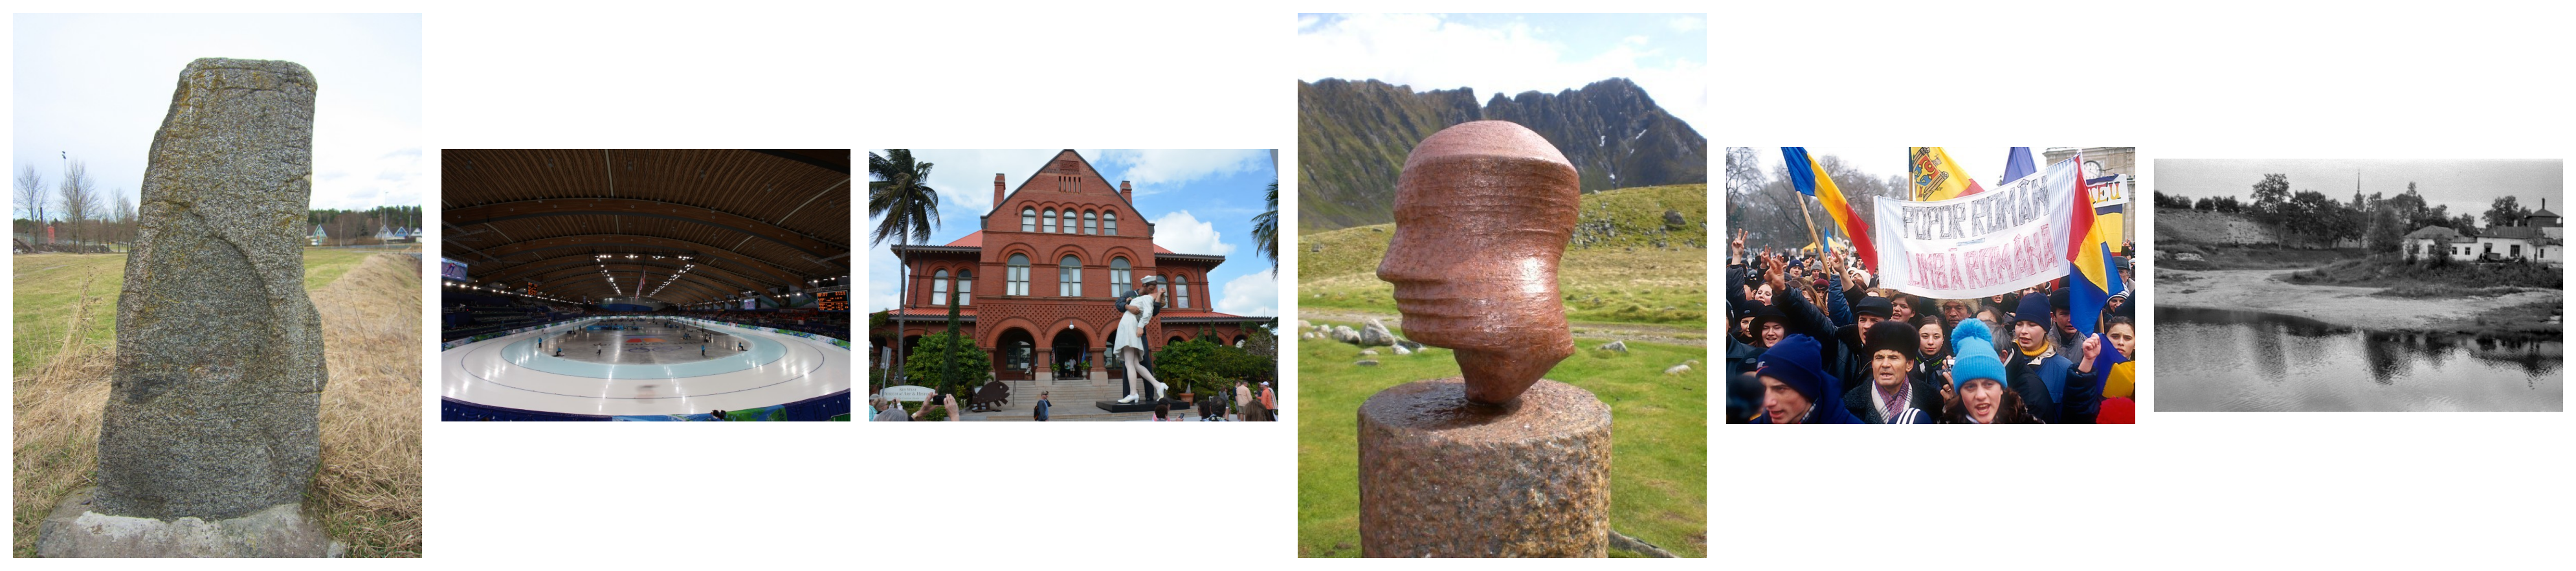

In [54]:
from fastai.vision.all import *
import matplotlib.pyplot as plt
from pathlib import Path

# Hàm để điều chỉnh đường dẫn tới ảnh
def fix_path(p):
    fn = str(p.name)  # Lấy tên tệp tin
    return p.parent / fn[0] / fn[1] / fn[2] / fn  # Tạo lại đường dẫn phù hợp

# Hàm lấy ảnh và kết quả từ dataframe
def image_results(row, n=5):
    # Sử dụng PILImage.create thay vì open_image để tạo danh sách ảnh
    # Ảnh query
    r = [PILImage.create(fix_path(Path('/content/drive/MyDrive/test') / (row.id + '.jpg')))]

    # 5 ảnh kết quả từ cột 'images' (cắt ra từ chuỗi)
    r.extend([PILImage.create(fix_path(Path('/content/drive/MyDrive/train') / (id + '.jpg'))) for id in row.images.split(' ')[:n]])

    return r

# Hàm để hiển thị các ảnh
def show_all(images, r=1, figsize=(20, 10)):
    # Số lượng ảnh quyết định số cột
    c = len(images)  # Số cột bằng số lượng ảnh
    fig, axs = plt.subplots(r, c, figsize=figsize)  # Tạo lưới subplots
    axs = axs.flatten()  # Chuyển thành mảng 1 chiều để dễ thao tác

    # Duyệt qua và hiển thị các ảnh
    for i, img in enumerate(images):
        axs[i].imshow(img)
        axs[i].axis('off')  # Tắt hiển thị trục của ảnh

    plt.tight_layout()  # Căn chỉnh các ảnh hợp lý
    plt.show()

# Ví dụ sử dụng show_all với dataframe
# Hiển thị ảnh của row thứ 10 trong dataframe sub_df
show_all(image_results(sub_df.iloc[11]), r=1, figsize=(20, 10))


In [ ]:
basename

In [ ]:
!kaggle competitions submit -c landmark-retrieval-2019 -f {sub_fname} -m '{basename} {index_type}'

In [ ]:
import time
time.sleep(10)

In [ ]:
!kaggle competitions submissions -c landmark-retrieval-2019 -v > submissions.csv

In [ ]:
submissions = pd.read_csv('submissions.csv')
submissions.iloc[0].publicScore